In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import sys
import os

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_7924\1517835734.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [8]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
os.environ['TORCH_HOME'] = './'

In [10]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(), #scale image to be between ZERO & ONE
    #min value = (0 - mean 0.5) / std 0.5 = -1
    #max value = (1 - mean 0.5) / std 0.5 = 1
    T.Normalize(
        mean=[0.5,0.5,0.5],
        std =[0.5,0.5,0.5]
        ),  
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])

In [14]:
# Step 2: convert into pytorch dataset 
train_data = torchvision.datasets.CIFAR10(
                                root='./data', 
                                download=True, 
                                train=True, 
                                transform=transform)

Files already downloaded and verified


In [30]:
print(train_data.data.shape)

(50000, 32, 32, 3)


In [46]:
# Step 4: Translate into dataloader objects
batchsize = 128
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

In [47]:
# unique class categories
print(train_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [48]:
X, y = next(iter(train_loader))
print(X.data.shape)

# for i in range(32):
#     ax = plt.subplot(4,8, i+1)
#     plt.imshow(imgs[i].squeeze().reshape(32,32), cmap='magma')
#     plt.xticks([])
#     plt.yticks([])

torch.Size([128, 3, 32, 32])


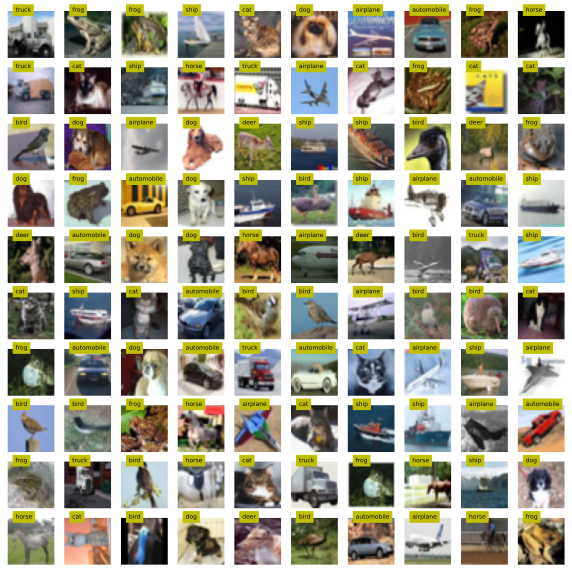

In [63]:
# check for a few random images
fix, axs = plt.subplots(10,10,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    #extract the image (transpose it back to 32x32x3) so matplot can understand it
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic / 2 + 0.5 #undo normalization
    
    label = train_data.classes[y[i]]
    
    ax.imshow(pic)
    ax.text(5,0, label, ha='left', color='k', backgroundcolor='y', fontsize=6) #fontweight='bold'
    ax.axis('off')



In [105]:
# 3*32*32 -> 1024 -> leaky_relu -> 1024 -> 256 -> leaky_relu -> 256 -> 1 -> sigmoid
class discriminatorModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input is 1024 = 32*32
        self.fc1 = nn.Linear(3*32*32,1024) #3072,1024
        self.fc2 = nn.Linear(1024,256) 
        self.out = nn.Linear(256,1)
        
    def forward(self,x):
        x = self.fc1( x )
        x = F.leaky_relu( x )
        
        x = self.fc2( x )
        x = F.leaky_relu( x )
        
        x = self.out( x )
        return torch.sigmoid( x )

In [106]:
# discriminator model instance
discrModel = discriminatorModel().to(device)

In [107]:
# test if the model works fine
y = discrModel(torch.randn(10,3072).to(device))

In [120]:
# 64 -> 256 -> leaky_relu -> 256 -> 1024 -> leaky_relu -> 1024 -> 3072 -> tanh
latent_space = 64

class generatorModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input is starting with a random noise of 64
        self.fc1 = nn.Linear(64,256)
        self.fc2 = nn.Linear(256,1024) 
        self.out = nn.Linear(1024,3072)
        
    def forward(self,x):
        x = self.fc1( x )
        x = F.leaky_relu( x )
        
        x = self.fc2( x )
        x = F.leaky_relu( x )
        
        x = self.out( x )
        return torch.tanh( x )

In [114]:
# generator model instance
genModel = generatorModel().to(device)

In [115]:
# test if the model works fine
y = genModel(torch.randn(32,64).to(device))

In [116]:
# Train the Model

In [117]:
# loss function
lossFun = nn.BCELoss()

# Model optimizers
discrOptim  =   torch.optim.Adam(discrModel.parameters(), lr=0.0003)
genOptim    =   torch.optim.Adam(genModel.parameters(), lr=0.0003)

In [118]:
train_loader.dataset.data.shape

(50000, 32, 32, 3)

In [121]:
epochs = 500

losses          = torch.zeros((epochs,2))
discrAccuracy = torch.zeros((epochs,2))

for epochi in range(epochs):
    
    # labels used for real & fakes images
    realLabels = torch.ones( batchsize, 1).to(device) 
    fakeLabels = torch.zeros(batchsize, 1).to(device)
    
    # load minibatch
    for n, (X, y) in enumerate(train_loader):
        
        #create mini batches of real & fake images
        realImages = X.to(device)
            # flatten the image for the ANN model
        realImages = realImages.reshape(batchsize, 3*32*32)
        fakeImages = genModel( torch.randn(batchsize, latent_space).to(device) )
        
        # # # # # # - - - - - - - - - - - - # # # # # #
        # # # - - - Train the Discriminator - - - # # #
        
        # forward pass & loss ==>> real images
        realPred   = discrModel(realImages)
        realLossDiscr = lossFun(realPred, realLabels)
        
        # forward pass & loss ==>> fake images
        fakePred   = discrModel(fakeImages)
        fakeLossDiscr = lossFun(fakePred, fakeLabels)
        
        # loss
        discrLoss = realLossDiscr + fakeLossDiscr*2
        losses[epochi,0]            = discrLoss.item()
        discrAccuracy[epochi,0]   = torch.mean( (realPred > 0.5).float() ).detach()
        
        # backprop
        discrOptim.zero_grad()
        discrLoss.backward()
        discrOptim.step()
        
        # # # # # # - - - - - - - - - - - - # # # # # #
        # # # - - - - Train the Generator - - - - # # #
        
        # create fakes images by generator then pass by discriminator
        fakeImages  = genModel( torch.randn(batchsize,latent_space).to(device) )
        fakePred    = discrModel(fakeImages)
        
        # compute loss & accuracy
        genLoss = lossFun(fakePred, realLabels)
        losses[epochi,1]        = genLoss.item()
        discrAccuracy[epochi,1] = torch.mean( (fakePred>0.5).float() ).detach()
        
        # backprop
        genOptim.zero_grad()
        genLoss.backward()
        genOptim.step()
    
    if (epochi+1) % 100 == 0:
        msg = f'Finished epoch {epochi+1}/{epochs}'
        sys.stdout.write('\r' + msg)


In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[::5,0], losses[::5,1], 'k.', alpha=0.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(discrAccuracy)
ax[2].set_xlabel('Epochs')
ax[2].set_xlabel('Probability of real')
ax[2].set_ylabel('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

In [ ]:
# eval mode
genModel.eval()

# generate images using the GAN network
fakeData = genModel( torch.randn(12,64).to(device) ).cpu()

#visualize
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fakeData[i,:,].detach().view(3,32,32))
    ax.axis('off')
    
plt.show()